### KNN Model

Load dataset

In [1]:
import pandas as pd

# load the dataset
dataset_path = 'cnn_news_articles_final_cleaned.csv'
df = pd.read_csv(dataset_path)

Split dataset

In [2]:
from sklearn.model_selection import train_test_split

# split into training and testing sets (70 30)
X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['sentiment'], test_size=0.3, random_state=42)

Encode labels

In [3]:
# encode labels (negative=0 positive=1 neutral=2)
y_train = y_train.map({'negative': 0, 'positive': 1, 'neutral': 2})
y_test = y_test.map({'negative': 0, 'positive': 1, 'neutral': 2})

Feature Extraction

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vector
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Train ML models

In [5]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_tfidf, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


KNeighborsClassifier()

MLflow Server

In [6]:
import mlflow
from mlflow.tracking import MlflowClient

# convert model name to string
model_name = knn_model.__class__.__name__

# start MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("sentiment-analysis")

# initialize MLflow client
client = MlflowClient()

# experiment ID
experiment_id = client.get_experiment_by_name("sentiment-analysis").experiment_id

runs = client.search_runs(experiment_ids=[experiment_id])

# initial version to 0
max_version = 0

# find the max version for the current version model
for run in runs:
    run_name = run.data.tags.get('mlflow.runName')
    if run_name and run_name.startswith(model_name):        
        # extract version number from the run name
        try:
            version = int(run_name.split('_v')[-1])
        except ValueError:
            continue  # skip if version is not an integer

        # update max_version if this version is greater
        max_version = max(max_version, version)

# increase the version by adding 1
new_version = max_version + 1

# new run name
new_run_name = f"{model_name}_v{new_version}"
mlflow.start_run(run_name=new_run_name)

mlflow.log_param("model name", model_name)
mlflow.log_param("dataset_name", dataset_path)
mlflow.log_param("data size", df.shape)

2024/09/14 03:41:31 INFO mlflow.tracking.fluent: Experiment with name 'sentiment-analysis' does not exist. Creating a new experiment.
2024/09/14 03:41:31 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    exp

(41688, 6)

Predict accuracy (Based model)

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# predict test 
y_pred = knn_model.predict(X_test_tfidf)

print("Based Model:")

#  training accuracy
trainAccuracy = knn_model.score(X_train_tfidf, y_train)
print("Training Accuracy:", trainAccuracy)

# test accuracy
testAccuracy = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", testAccuracy)

# precison recall f1score
print(classification_report(y_test, y_pred))

Based Model:
Training Accuracy: 0.780747746821562
Testing Accuracy: 0.6518749500279843
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      4444
           1       0.69      0.54      0.61      3043
           2       0.60      0.75      0.67      5020

    accuracy                           0.65     12507
   macro avg       0.67      0.64      0.64     12507
weighted avg       0.66      0.65      0.65     12507



Confusion matrix (Based model)

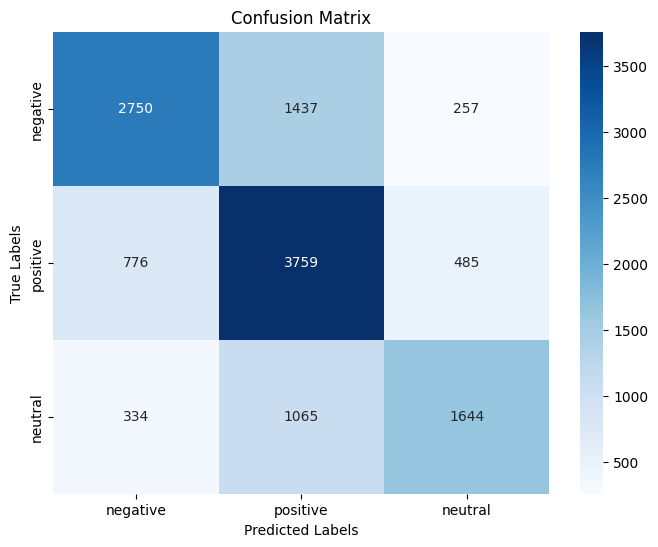

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# decode the labels back to original
reverse_mapping = {0: 'negative', 1: 'positive', 2: 'neutral'}
decoded_y_pred = [reverse_mapping[label] for label in y_pred]
decoded_y_test = [reverse_mapping[label] for label in y_test]

# create confusion matrix
conf_matrix = confusion_matrix(decoded_y_test, decoded_y_pred)

# plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['negative', 'positive', 'neutral'])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['negative', 'positive', 'neutral'])
plt.show()

ROC curve (Based model)

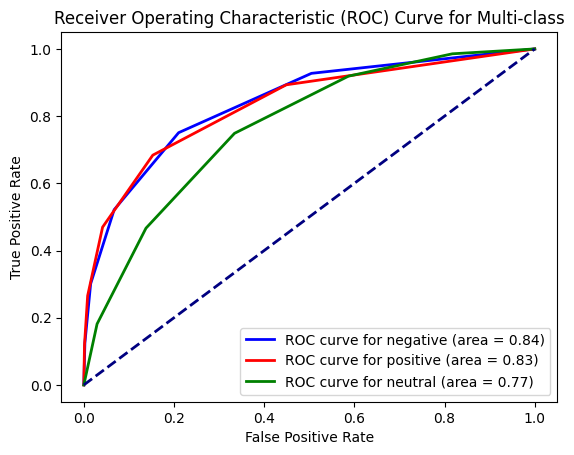

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# proba for proba models , decision for svm
y_pred_scores = knn_model.predict_proba(X_test_tfidf)

# compute and plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_scores[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_scores[:, i])

plt.figure()

colors = ['blue', 'red', 'green']
classes = ['negative', 'positive', 'neutral']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()

Grid search for Fine-tuning models (Hypertuning)

In [14]:
from sklearn.model_selection import GridSearchCV

# KNN classifier            
knn_model = KNeighborsClassifier()

# hyperparameters to tune 
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# perform grid search with cross-validation
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='accuracy')

# fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# best hyperparameters and corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# make predictions
best_model = grid_search.best_estimator_
predictions_test = best_model.predict(X_test_tfidf)

# calculate accuracy 
best_model_train_score = best_model.score(X_train_tfidf, y_train)
best_model_test_score = best_model.score(X_test_tfidf, y_test)

print()
print("Best Model:")
print("Training Score: {}\nTest Score: {}".format(best_model_train_score, best_model_test_score))

# classification report
report = classification_report(y_test, predictions_test, output_dict=True)

print("\nClassification Report:")
print(classification_report(y_test, predictions_test))

mlflow.log_param("best params", best_params)

mlflow.log_metric("train accuracy", best_model_train_score)
mlflow.log_metric("test accuracy", best_model_test_score)

mlflow.log_metric("Precision", report['weighted avg']['precision'])
mlflow.log_metric("Recall", report['weighted avg']['recall'])
mlflow.log_metric("F1 Score", report['weighted avg']['f1-score'])

C:\Users\Joe Chok\AppData\Roaming\Python\Python312\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\Joe Chok\AppData\Roaming\Python\Python312\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\Joe Chok\AppData\Roaming\Python\Python312\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\Joe Chok\AppData\Roaming\Python\Python312\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\Joe Chok\AppData\Roaming\Python\Python312\site-pack

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.6665638349950911

Best Model:
Training Score: 0.7683766834584147
Test Score: 0.6639481890141521

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      4444
           1       0.73      0.52      0.61      3043
           2       0.60      0.79      0.68      5020

    accuracy                           0.66     12507
   macro avg       0.69      0.64      0.66     12507
weighted avg       0.68      0.66      0.66     12507



Confusion matrix (Best model)

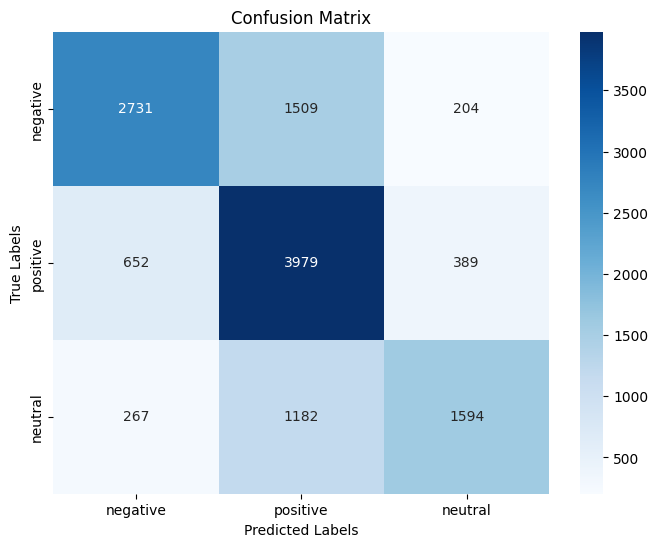

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# decode the labels back to original
reverse_mapping = {0: 'negative', 1: 'positive', 2: 'neutral'}
decoded_y_pred = [reverse_mapping[label] for label in predictions_test]
decoded_y_test = [reverse_mapping[label] for label in y_test]

# create confusion matrix
conf_matrix = confusion_matrix(decoded_y_test, decoded_y_pred)

# plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['negative', 'positive', 'neutral'])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['negative', 'positive', 'neutral'])
plt.show()

ROC curve (Best model)

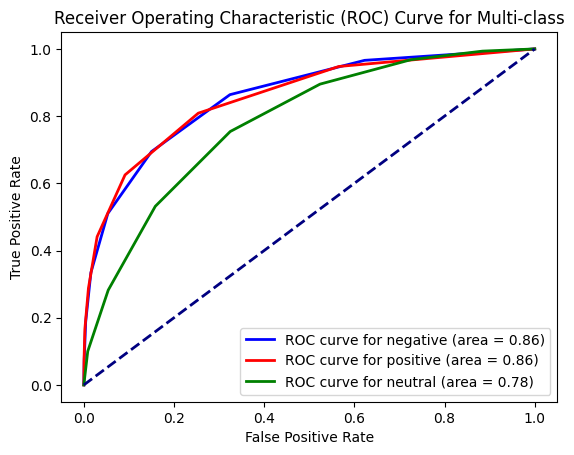

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# proba for proba models , decision for svm
y_pred_scores = best_model.predict_proba(X_test_tfidf)

# compute and plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_scores[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_scores[:, i])

plt.figure()

colors = ['blue', 'red', 'green']
classes = ['negative', 'positive', 'neutral']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()

Random Test Unseen data

In [23]:
label_encoding = {0: 'negative', 1: 'positive', 2: 'neutral'}

# unseen data
input_text = "McDonald’s shortens breakfast time in Australia as bird flu causes egg shortage"
# input_text = "Tesla sales fall again as more automakers crowd electric vehicle market"
# input_text = "today is a bad day"

transformed_input = tfidf_vectorizer.transform([input_text])
prediction = best_model.predict(transformed_input)

# decode the label into its original class
decoded_prediction = label_encoding[prediction[0]]

print(f"Prediction: {decoded_prediction}")

Prediction: negative


#### Performance

Based Accuracy = 65%

Fine Tuned Accuracy = 66%